In [1]:
import cffi

ffi = cffi.FFI()
ffi.cdef('void prox_dp_C(int n, double *y, double lam, double *theta);')

ffi.set_source('_prox', r'''
extern "C" {
    void prox_dp_C(int n, double *y, double lam, double *theta);
}
''', sources=['prox.cpp'], source_extension='.cpp')

ffi.compile(verbose=True)

import _prox
import numpy as np

def prox_dp(n, y, lam, theta):
    '''
    Dynamic programming algorithm for the 1d fused lasso problem:
    \min_\theta \frac{1}{2} \sum_i (y_i - \theta_i)^2 + 
                            \lambda \sum_i |\theta_i - \theta_{i+1}|
    (Ryan's implementation of Nick Johnson's algorithm)

    Input:
        n: int
        y: np.float64 array of shape (n,)
        lam: float

    Output:
        theta: np.float64 array of shape (n,)
    '''
    assert y.dtype == np.float64 and y.shape[0] == n
    assert theta.dtype == np.float64 and theta.shape[0] == n

    _prox.lib.prox_dp_C(n, ffi.from_buffer('double[]', y), lam, ffi.from_buffer('double[]', theta))


generating .\_prox.cpp
(already up-to-date)
the current directory is 'D:\\work\\10-725 convex optimization\\hw4'
running build_ext
building '_prox' extension
C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD "-Ic:\program files\python36\include" "-Ic:\program files\python36\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.6.1\include\um" "-ID:\Windows Kits\10\include\10.0.17763.0\ucrt" "-ID:\Windows Kits\10\include\10.0.17763.0\shared" "-ID:\Windows Kits\10\include\10.0.17763.0\um" "-ID:\Windows Kits\10\include\10.0.17763.0\winrt" "-ID:\Windows Kits\10\include\10.0.17763.0\cppwinrt" /EHsc /Tp_prox.cpp /Fo.\Release\_prox.obj
C:\Program Files (x86)\Microsoft Visual Studio\2017\Co

In [31]:
train_y = np.loadtxt('binseq.txt', delimiter=',')
n = train_y.shape[0]

## HW3 4a: solve primal use backtracking proximal GD

In [3]:
total_cnt = 0

def eval_prob(theta):
    eb = np.exp(theta)
    return eb/(1+eb) 

def eval_g(y, theta):
    eb = np.exp(theta)
    g = -np.dot(y, theta) + np.sum(np.log(1+eb))
    return g

def eval_nabla_g(y, theta):
    eb = np.exp(theta)
    nabla_g = eb/(1+eb) - y
    return nabla_g

def eval_h(theta, lamba):
    return np.linalg.norm(theta[1:]-theta[:-1], ord=1)*lamda

def eval_criterion(y, theta, lamda):
    return eval_g(y, theta) + eval_h(theta, lamda)
    
def proximal_update(y, theta, lamda, t):
    # update
    # step 1: solve $\nabla g$
    nabla_g = eval_nabla_g(y, theta)
    # step 2: get $theta-t\nabla g$
    z = theta - t*nabla_g
    # step 3: solve proximal
    new_theta = np.zeros((n,))
    prox_dp(n, z, lamda*t, new_theta)
    return new_theta


def backtrack_proximal_update(y, theta, lamda, t, shrinkage):
    global total_cnt
    gb = eval_g(y, theta)
    ngb = eval_nabla_g(y, theta)
    while True:
        total_cnt += 1
        new_theta = proximal_update(y, theta, lamda, t)
        G = (theta-new_theta)/t
        lhs = eval_g(y, new_theta)
        rhs = gb - t*np.dot(ngb, G) + t/2*np.dot(G, G)
        #print(lhs, rhs)
        if lhs > rhs:
            # print('shrinkage happen!')
            t = shrinkage * t
        else:
            return new_theta
        
primal_theta = np.zeros((n,))
lamda = 20
tolerance = 1e-6
criterion = float('inf')
while True:
    new_criterion = eval_criterion(train_y, primal_theta, lamda)
    #print(criterion - new_criterion)
    if (criterion - new_criterion < tolerance):
        break
    primal_theta = backtrack_proximal_update(train_y, primal_theta, lamda, t=1, shrinkage=0.8)
    criterion = new_criterion


total iter 53


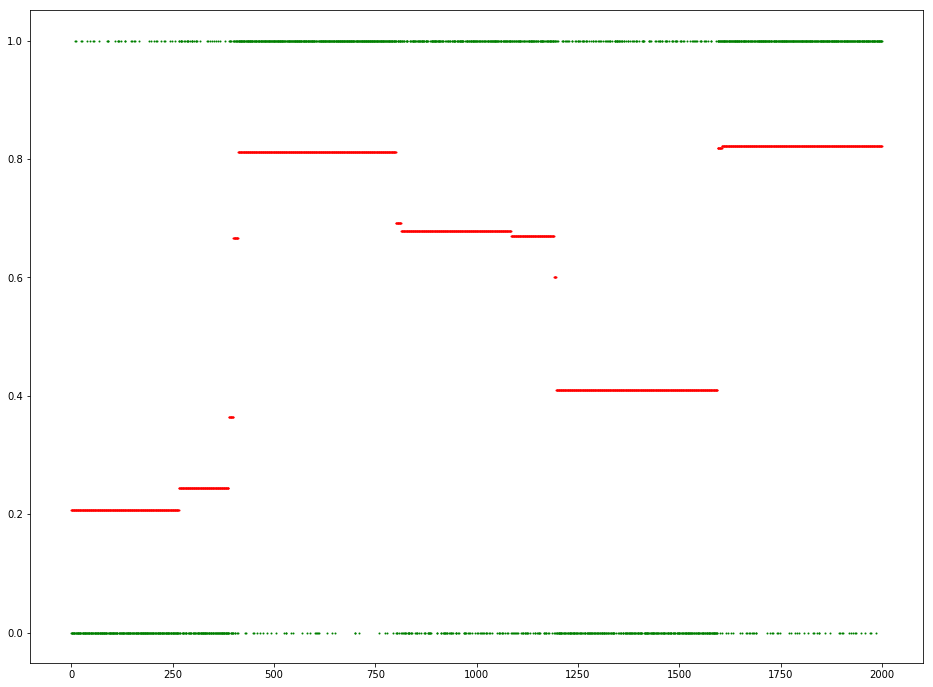

In [4]:
print('total iter', total_cnt)
primal_theta_copied = primal_theta.copy()
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
plt.scatter(range(n), train_y, s=1, c='g')
plt.scatter(range(n), eval_prob(primal_theta_copied), s=1, c='r')
plt.show()

## HW3 4c: find feasible $u_0$

In [5]:
import cvxpy as cp
import numpy as np

In [32]:
def get_init_u(train_y, lamda):
    u = cp.Variable(n-1)
    d = cp.Variable(1)

    d0 = 1e-5
    D = np.zeros((n-1, n))
    rg = np.array(range(n-1))
    D[rg, rg] = 1
    D[rg, rg+1] = -1

    y = 2*train_y - 1
    objective = cp.Maximize(d)
    constraint = [d >= d0, d <= lamda, u <= lamda-d, u >= d-lamda, cp.multiply(y, D.T@u) >= d, cp.multiply(y, D.T@u) <= 1-d]
    problem = cp.Problem(objective, constraint)

    result = problem.solve(solver=cp.SCS, max_iters=10000, verbose=True)
    # print(u.value, d.value)
    return u.value
init_u = get_init_u(train_y, lamda=1e-3)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 19994
eps = 1.00e-04, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 2000, constraints m = 8000
Cones:	linear vars: 8000
WARN: aa_init returned NULL, no acceleration applied.
Setup time: 1.24e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.13e+20  1.05e+22  6.43e-01 -7.84e+19 -1.70e+19  6.82e+21  1.32e-01 
   100| 1.01e-04  2.54e-05  2.63e-05 -2.12e-04 -1.85e-04  5.78e-19  1.76e-01 
   120| 7.91e-05  6.82e-05  2.26e-05 -1.90e-04 -1.67e-04  5.78e-19 

## HW3 4d: solve dual using backtracking GD

In [7]:
max_iter = 50000

def fast_DTu(u):
    return np.concatenate([u, [0]]) - np.concatenate([[0], u])

def fast_Dx(x):
    return x[:-1] - x[1:]

def eval_f(y, u, lamda, tau):
    z = y*fast_DTu(u)
    #print(z.max(), z.min())
    f1 = (z*np.log(z)+(1-z)*np.log(1-z)).sum()
    f2 = -(np.log(z)+np.log(1-z)).sum()/tau
    f3 = -(np.log(lamda-u)+np.log(lamda+u)).sum()/tau
    #print(f1, f2, f3)
    return f1+f2+f3

def eval_nabla_f(y, u, lamda, tau):
    z = y*fast_DTu(u)
    w = y*(np.log(z/(1-z))-(1/z-1/(1-z))/tau)
    
    return fast_Dx(w) + 2*u/(lamda*lamda-u*u)/tau

def check_u_valid(u):
    z = y*fast_DTu(u)
    if z.min()<=0:
        return False
    if z.max()>=1:
        return False
    if np.abs(u).max() >= lamda:
        return False
    return True


In [8]:
y = 2*train_y - 1
arr = y*fast_DTu(init_u)
print(arr.max(), arr.min())
print(np.abs(init_u).max())

0.8267821177707413 0.17234848083823806
19.827744926439742


In [10]:
from tqdm import tqdm
def backtrack_dual(y, u, lamda, tau, shrinkage=0.8, init_t=1):
    t = init_t
    f = eval_f(y, u, lamda, tau)
    grad = eval_nabla_f(y, u, lamda, tau)
    g2 = np.dot(grad, grad)
    while True:
        new_u = u - t * grad
        if not check_u_valid(new_u):
            t *= shrinkage
            continue
        lhs = eval_f(y, new_u, lamda, tau)
        rhs = f - t/2*g2
        if lhs > rhs:
            t *= shrinkage
            continue
        else:
            break
    return u - t * grad

dual_u = init_u
# for it in range(max_iter):
#     dual_u = backtrack_dual(y, dual_u, lamda, tau=1e3)


In [11]:
def theta_from_u(y, u):
    DTu = fast_DTu(u)
    return np.log(y/DTu-1)/y

dual_theta = theta_from_u(y, dual_u)

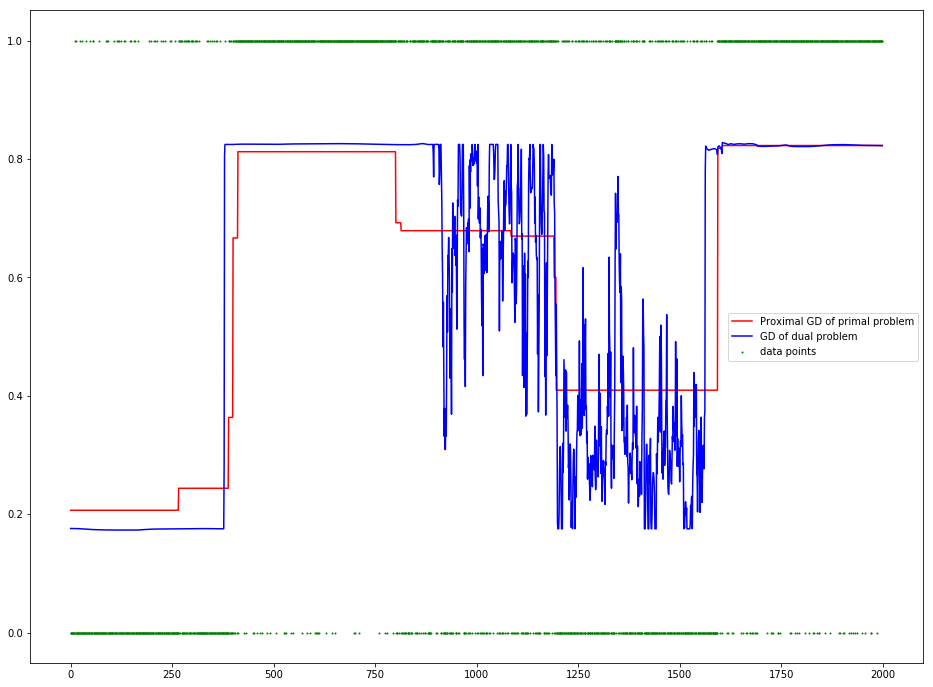

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
plt.scatter(range(n), train_y, s=1, c='g', label='data points')
plt.plot(range(n), eval_prob(primal_theta), c='r', label='Proximal GD of primal problem')
plt.plot(range(n), eval_prob(dual_theta), c='b', label='GD of dual problem')
plt.legend()
plt.show()

In [13]:
primal_criterion = eval_criterion(train_y, primal_theta, lamda)
dual_criterion = eval_criterion(train_y, dual_theta, lamda)
print(primal_criterion, dual_criterion)

1114.338270517136 4306.878349320154


## HW4 3a: Newton's method for dual

In [14]:
def eval_nabla_f(y, u, lamda, tau):
    x = y*fast_DTu(u)
    w = y*(np.log(x/(1-x))-(1/x-1/(1-x))/tau)
    
    return fast_Dx(w) + 2*u/(lamda*lamda-u*u)/tau

def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc


def eval_newton_step(y, u, lamda, tau):
    """
    Return \nabla^2 f^(u){-1} \nabla f(u)
    """
    x = y*fast_DTu(u)
    v = 1/x/(1-x) + (1/x/x+1/(1-x)/(1-x))/tau
    d = 2*(lamda*lamda+u*u)/(lamda*lamda-u*u)/(lamda*lamda-u*u)/tau
    nabla_f = eval_nabla_f(y, u, lamda, tau)
    hessian_primary_diagonal = v[:-1]+v[1:] + d
    hessian_secondary_diagonal = -v[1:-1]
    n = y.shape[0]
    return TDMAsolver(hessian_secondary_diagonal, hessian_primary_diagonal, hessian_secondary_diagonal, nabla_f)
    
#     hessian_f = np.zeros((n-1, n-1))
#     hessian_f[range(n-1), range(n-1)] = hessian_primary_diagonal
#     hessian_f[np.arange(n-2), np.arange(n-2)+1] = hessian_secondary_diagonal
#     hessian_f[np.arange(n-2)+1, np.arange(n-2)] = hessian_secondary_diagonal
        
    
    
#     return np.linalg.inv(hessian_f)@nabla_f




In [15]:
def backtrack_dual_newton(y, u, init_lamda, init_tau, shrinkage=0.8, init_t=1):
    t = init_t
    f = eval_f(y, u, init_lamda, init_tau)
    nabla_f = eval_nabla_f(y, u, init_lamda, init_tau)
    newton_step = eval_newton_step(y, u, init_lamda, init_tau)
    while True:
        new_u = u - t * newton_step
        if not check_u_valid(new_u):
            t *= shrinkage
            continue
        lhs = eval_f(y, new_u, init_lamda, init_tau)
        rhs = f - t* nabla_f@newton_step/2
        # print(lhs, rhs)
        if lhs > rhs:
            t *= shrinkage
            # print('shrinkage')
            continue
        else:
            break
    return u - t * newton_step

dual_newton_u = init_u
tolerance = 1e-6
criterion = float('inf')
total_cnt = 0
while True:
    new_criterion = eval_f(y, dual_newton_u, lamda, tau=1e3)
    print('criterion', criterion, new_criterion)
    if (criterion - new_criterion< tolerance):
        break
    dual_newton_u = backtrack_dual_newton(y, dual_newton_u, lamda, init_tau=1e3)
    criterion = new_criterion
    total_cnt += 1
print('total iter', total_cnt)

criterion inf -1023.8315984552854
criterion -1023.8315984552854 -1031.1471315329495
criterion -1031.1471315329495 -1041.7186409972858
criterion -1041.7186409972858 -1043.8903316888843
criterion -1043.8903316888843 -1048.947126268861
criterion -1048.947126268861 -1051.828013588493
criterion -1051.828013588493 -1055.6246909223887
criterion -1055.6246909223887 -1086.4283389508023
criterion -1086.4283389508023 -1091.977345568109
criterion -1091.977345568109 -1094.201935477348
criterion -1094.201935477348 -1097.689429228981
criterion -1097.689429228981 -1108.3332063548216
criterion -1108.3332063548216 -1112.5119551435462
criterion -1112.5119551435462 -1115.3252445516323
criterion -1115.3252445516323 -1118.8102250745235
criterion -1118.8102250745235 -1119.265617934248
criterion -1119.265617934248 -1119.784792548654
criterion -1119.784792548654 -1121.2442577330391
criterion -1121.2442577330391 -1121.2942336113035
criterion -1121.2942336113035 -1121.2963843523598
criterion -1121.2963843523598 

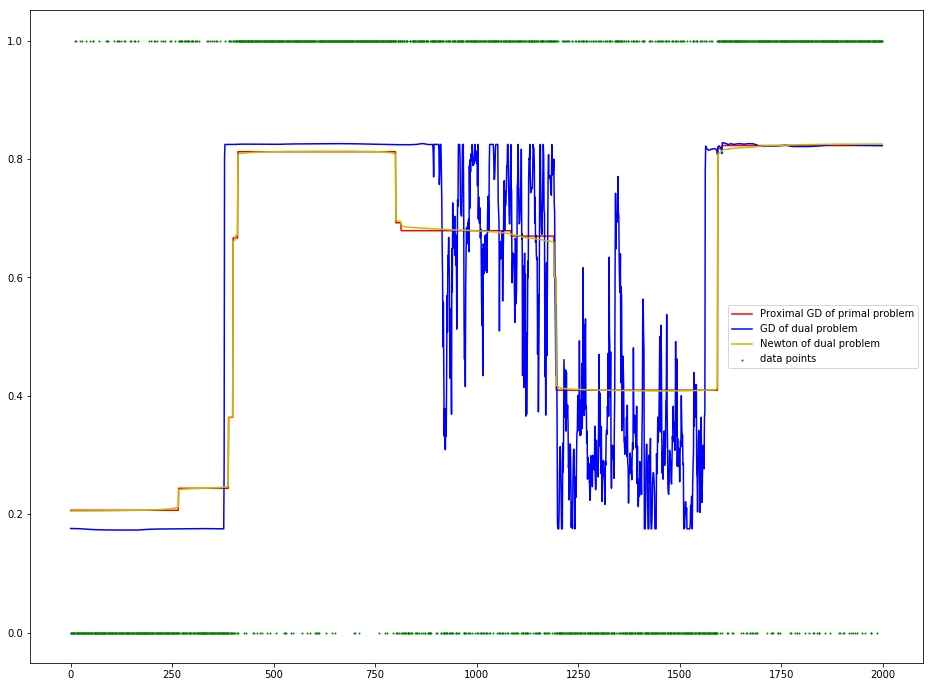

In [16]:

dual_newton_theta = theta_from_u(y, dual_newton_u)
dual_newton_theta_copied = dual_newton_theta.copy()

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
plt.scatter(range(n), train_y, s=1, c='g', label='data points')
plt.plot(range(n), eval_prob(primal_theta_copied), c='r', label='Proximal GD of primal problem')
plt.plot(range(n), eval_prob(dual_theta), c='b', label='GD of dual problem')
plt.plot(range(n), eval_prob(dual_newton_theta_copied), c='y', label='Newton of dual problem')
plt.legend()
plt.show()

## HW4 3b: Newton's method for dual compared to primal solution

In [17]:

criterions = np.zeros((100, 2, 2)) # (n, idx_lamda, 0 if primal else 1)
for i, lamda in enumerate([20, 0.02]):
    dual_newton_u = get_init_u(train_y, lamda)
    primal_theta = np.zeros((n,))
    for iteration in range(100):
        new_primal_criterion = eval_criterion(train_y, primal_theta, lamda)

        dual_newton_theta = theta_from_u(y, dual_newton_u)
        new_dual_criterion = eval_criterion(train_y, dual_newton_theta, lamda)
        # print(lamda, iteration, 'primal', new_primal_criterion, 'dual', new_dual_criterion)
        criterions[iteration, i, 0] = new_primal_criterion
        criterions[iteration, i, 1] = new_dual_criterion

        dual_newton_u = backtrack_dual_newton(y, dual_newton_u, lamda, init_tau=1e3)
        primal_theta = backtrack_proximal_update(train_y, primal_theta, lamda, t=1, shrinkage=0.8)
        


WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


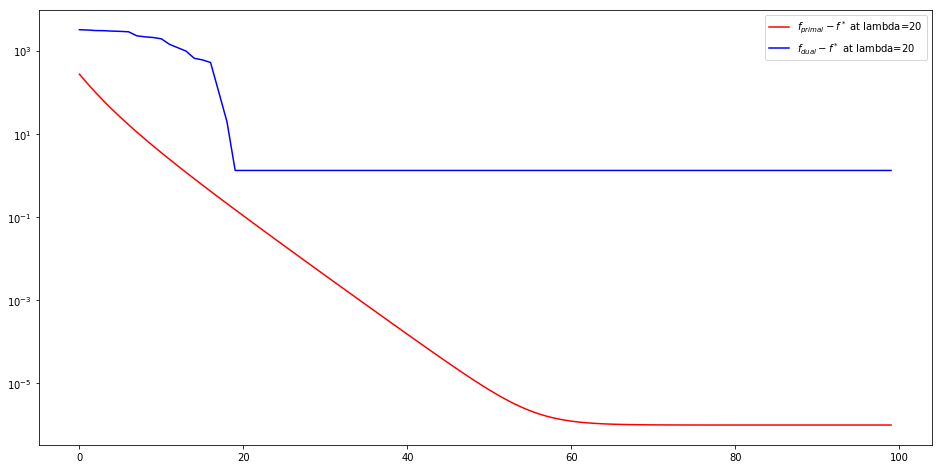

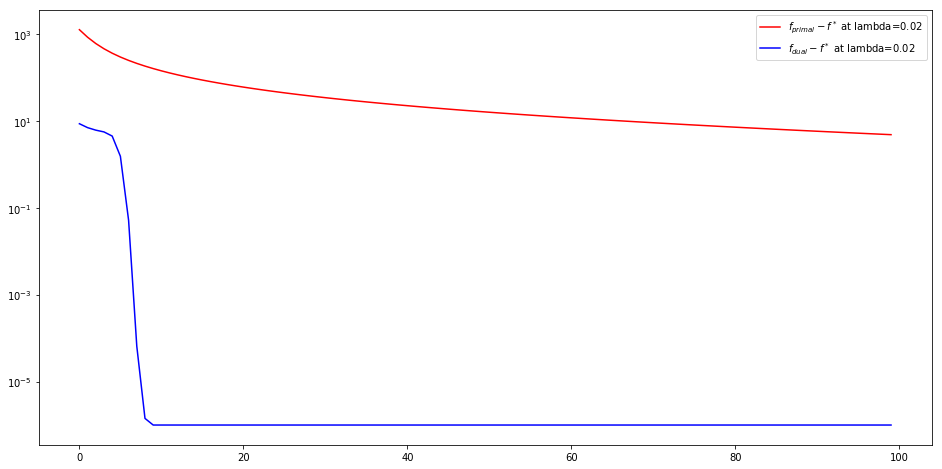

In [18]:
for i, lamda in enumerate([20, 0.02]):
    minimal = criterions[:,:,:].min(2).min(0)[i] - 1e-6
    plt.figure(figsize=(16,8))
    plt.plot(range(100), criterions[:,i,0]-minimal, c='r', label='$f_{}-f^*$ at lambda={}'.format('{primal}',lamda))
    plt.plot(range(100), criterions[:,i,1]-minimal, c='b', label='$f_{}-f^*$ at lambda={}'.format('{dual}',lamda))
    # plt.plot(range(100), np.abs(criterions[:,i,1]-criterions[:,i,0]), c='g', label=f'Duality Gap at lambda={lamda}')
    plt.yscale('log')
    plt.legend()
    plt.show()

## HW4 4a: the barrier method

In [19]:
# barrier loop
total_cnt = 0
lamda = 20
def perform_barrier(y, init_u, barrier_lamda, init_tau=5, inner_tol=1e-6, outer_tol=1e-8, mu=10, max_iter=100):
    global total_cnt
    dual_barrier_u = init_u.copy()
    tau = init_tau
    n = len(y)
    m = 4*n-2
    for outer_iter in range(max_iter):
        # print('new tau', tau)
        if m/tau < outer_tol:
            break
        criterion = float('inf')
        # newton loop
        while True:
            new_criterion = eval_f(y, dual_barrier_u, barrier_lamda, tau)
            # print('criterion', criterion, new_criterion)
            if (criterion - new_criterion< inner_tol):
                break
            dual_barrier_u = backtrack_dual_newton(y, dual_barrier_u, barrier_lamda, tau)
            criterion = new_criterion
            total_cnt += 1
        # update params
        tau *= mu
    return dual_barrier_u

dual_barrier_u = get_init_u(train_y, lamda=20)
dual_barrier_u = perform_barrier(y, dual_barrier_u, barrier_lamda=20, max_iter=10000)

WARN: aa_init returned NULL, no acceleration applied.


In [20]:
print('total_cnt', total_cnt)

total_cnt 55


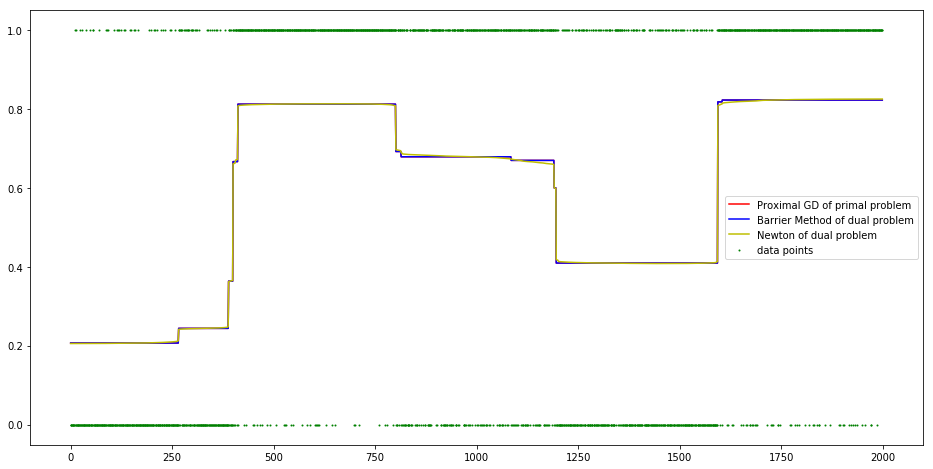

In [21]:
dual_barrier_theta = theta_from_u(y, dual_barrier_u)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.scatter(range(n), train_y, s=1, c='g', label='data points')
plt.plot(range(n), eval_prob(primal_theta_copied), c='r', label='Proximal GD of primal problem')
plt.plot(range(n), eval_prob(dual_barrier_theta), c='b', label='Barrier Method of dual problem')
plt.plot(range(n), eval_prob(dual_newton_theta_copied), c='y', label='Newton of dual problem')
plt.legend()
plt.show()

## HW4 4b Warm and Cool Restarts

In [22]:
total_iters_primal = np.zeros((80, 2)) # idx_lambda, 0 if cold and 1 if warm
criterions_primal = np.zeros((80, 2)) 
lamdas = np.logspace(start=np.log10(200), stop=np.log10(1e-3), num=80)
# cold restart
for i, lamda in enumerate(lamdas):
    total_cnt = 0
    criterion = float('inf')
    primal_theta = np.zeros((n,))
    for proximal_iter in range(1000):
    # while True:
        new_criterion = eval_criterion(train_y, primal_theta, lamda)
        #print(criterion - new_criterion)
        if (criterion - new_criterion < tolerance):
            break
        primal_theta = backtrack_proximal_update(train_y, primal_theta, lamda, t=1, shrinkage=0.8)
        criterion = new_criterion
    total_iters_primal[i, 0] = total_cnt
    criterions_primal[i, 0] = criterion
        
# warm restart
primal_theta = np.zeros((n,))
for i, lamda in enumerate(lamdas):
    total_cnt = 0
    criterion = float('inf')
    for proximal_iter in range(1000):
    # while True:
        new_criterion = eval_criterion(train_y, primal_theta, lamda)
        #print(criterion - new_criterion)
        if (criterion - new_criterion < tolerance):
            break
        primal_theta = backtrack_proximal_update(train_y, primal_theta, lamda, t=1, shrinkage=0.8)
        criterion = new_criterion
    total_iters_primal[i, 1] = total_cnt
    criterions_primal[i, 1] = criterion
        


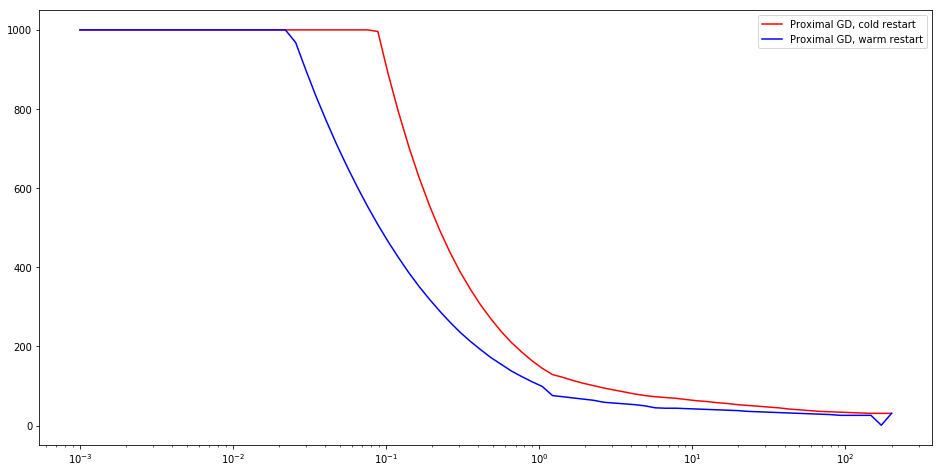

In [23]:
plt.figure(figsize=(16,8))
plt.plot(lamdas, total_iters_primal[:, 0], c='r', label='Proximal GD, cold restart')
plt.plot(lamdas, total_iters_primal[:, 1], c='b', label='Proximal GD, warm restart')
plt.legend()
plt.xscale('log')
plt.show()

## HW4 4c Warm and cool restart for Barrier methods

In [24]:
total_iters_dual = np.zeros((80, 2)) # idx_lambda, 0 if cold and 1 if warm
criterions_dual = np.zeros((80, 2)) 
    
# cold restart
dual_barrier_u_init = get_init_u(train_y, lamda=1e-3)
for i, lamda in enumerate(lamdas[::-1]):
    total_cnt = 0
    dual_barrier_u = perform_barrier(y, dual_barrier_u_init, lamda, max_iter=100)
    total_iters_dual[79-i, 0] = total_cnt
    dual_barrier_theta = theta_from_u(y, dual_barrier_u)
    criterions_dual[79-i, 0] = eval_criterion(train_y, dual_barrier_theta, lamda)
        
# warm restart
dual_barrier_u = dual_barrier_u_init
for i, lamda in enumerate(lamdas[::-1]):
    total_cnt = 0
    dual_barrier_u = perform_barrier(y, dual_barrier_u, lamda, max_iter=100)
    total_iters_dual[79-i, 1] = total_cnt
    dual_barrier_theta = theta_from_u(y, dual_barrier_u)
    criterions_dual[79-i, 1] = eval_criterion(train_y, dual_barrier_theta, lamda)
        


WARN: aa_init returned NULL, no acceleration applied.


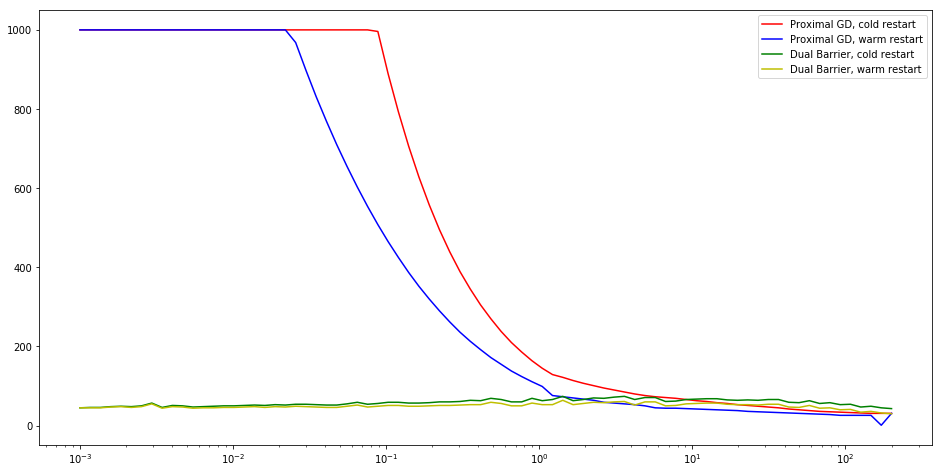

In [25]:
plt.figure(figsize=(16,8))
plt.plot(lamdas, total_iters_primal[:, 0], c='r', label='Proximal GD, cold restart')
plt.plot(lamdas, total_iters_primal[:, 1], c='b', label='Proximal GD, warm restart')
plt.plot(lamdas, total_iters_dual[:, 0], c='g', label='Dual Barrier, cold restart')
plt.plot(lamdas, total_iters_dual[:, 1], c='y', label='Dual Barrier, warm restart')
plt.legend()
plt.xscale('log')
plt.show()

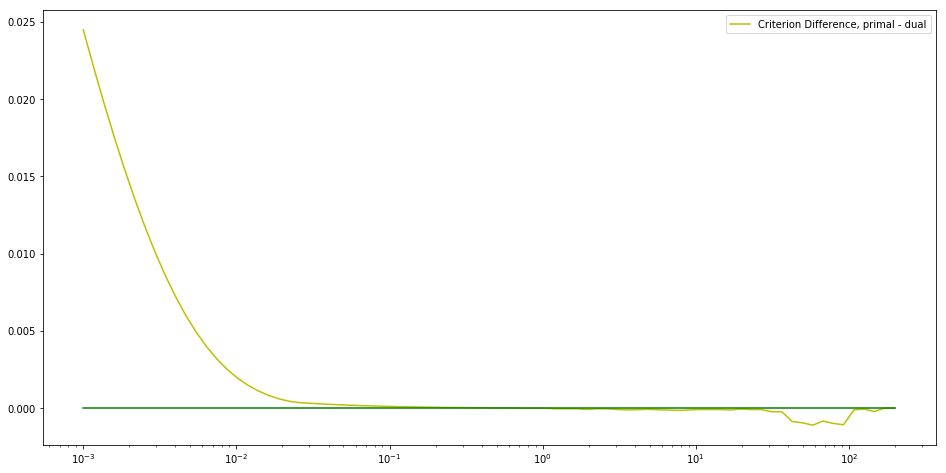

In [26]:
plt.figure(figsize=(16,8))
# plt.plot(lamdas, criterions_primal[:, 1], c='r', label='Criterion of Proximal GD, warm restart')
# plt.plot(lamdas, criterions_dual[:, 1], c='g', label='Criterion of Dual Barrier, warm restart')
plt.plot(lamdas, criterions_primal[:, 1] - criterions_dual[:, 1], c='y', label='Criterion Difference, primal - dual')
plt.plot(lamdas, np.zeros_like(lamdas), c='g')
plt.legend()
plt.xscale('log')
plt.show()

## HW4 4a complexity of proximal and newton step

In [27]:
question_size_list = np.logspace(2, 4, num=50)
time_comsumed = np.zeros((50, 2))

import timeit

lamda = 1
tau = 1e3
for i, question_size in enumerate(question_size_list):
    n = int(question_size)
    print('question size', n)
    # generate random question
    z = np.random.randint(0,2,size=n).astype(np.float64)
    y = 2*z-1
    
    number = 1
    if question_size < 5e3:
        number *= 10
    if question_size < 5e2:
        number * 10
    
    # time of primal prox
    new_theta = np.random.random((n,))
    def primal():
        prox_dp(n, z, lamda, new_theta)
    elapsed_time = timeit.timeit(primal, number=number)/number
    time_comsumed[i, 0] = elapsed_time
    # time of dual newton
    init_u = get_init_u(z, lamda)
    def dual():
        eval_newton_step(y, init_u, lamda, tau)
    elapsed_time = timeit.timeit(dual, number=number)/number
    time_comsumed[i, 1] = elapsed_time
    
    

question size 100
WARN: aa_init returned NULL, no acceleration applied.
question size 109
WARN: aa_init returned NULL, no acceleration applied.
question size 120
WARN: aa_init returned NULL, no acceleration applied.
question size 132
WARN: aa_init returned NULL, no acceleration applied.
question size 145
WARN: aa_init returned NULL, no acceleration applied.
question size 159
WARN: aa_init returned NULL, no acceleration applied.
question size 175
WARN: aa_init returned NULL, no acceleration applied.
question size 193
WARN: aa_init returned NULL, no acceleration applied.
question size 212
WARN: aa_init returned NULL, no acceleration applied.
question size 232
WARN: aa_init returned NULL, no acceleration applied.
question size 255
WARN: aa_init returned NULL, no acceleration applied.
question size 281
WARN: aa_init returned NULL, no acceleration applied.
question size 308
WARN: aa_init returned NULL, no acceleration applied.
question size 339
WARN: aa_init returned NULL, no acceleration a

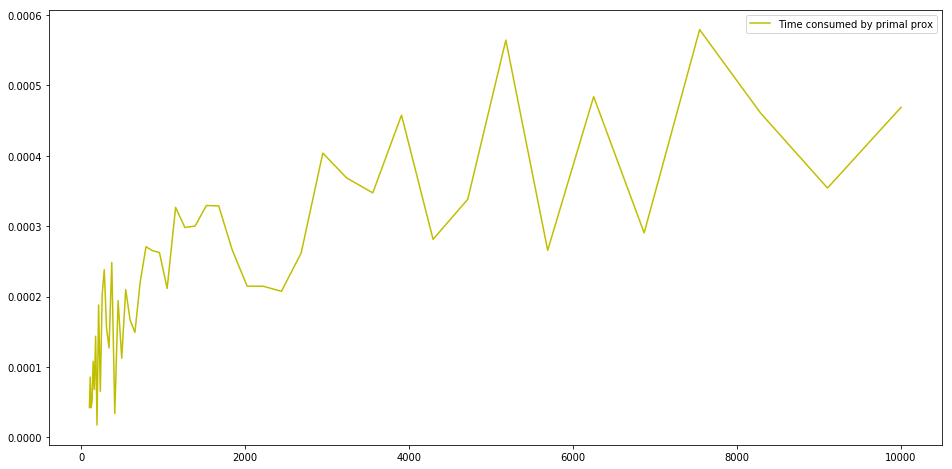

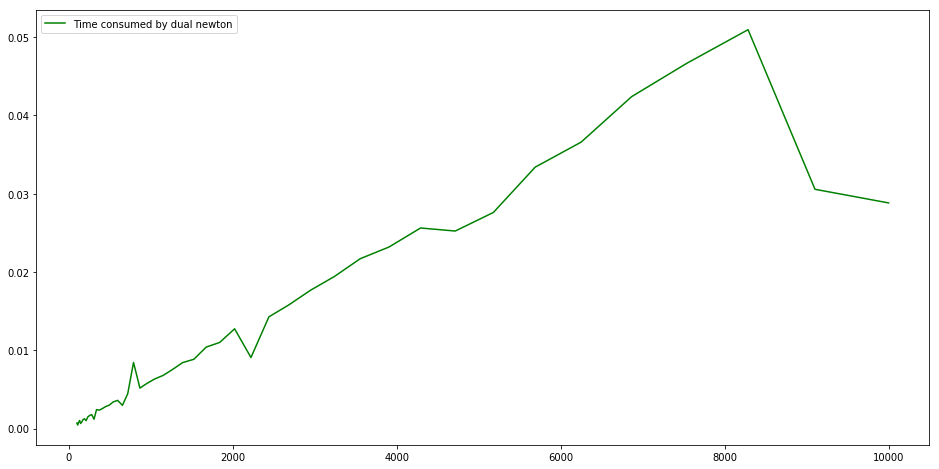

In [28]:
plt.figure(figsize=(16,8))
plt.plot(question_size_list, time_comsumed[:, 0], c='y', label='Time consumed by primal prox')
plt.legend()
plt.show()
plt.figure(figsize=(16,8))
plt.plot(question_size_list, time_comsumed[:, 1], c='g', label='Time consumed by dual newton')
plt.legend()
plt.show()

In [29]:
time_comsumed

array([[4.249000e-05, 7.170900e-04],
       [8.579000e-05, 4.587600e-04],
       [4.209000e-05, 7.969600e-04],
       [5.130000e-05, 1.031940e-03],
       [1.081800e-04, 6.565800e-04],
       [6.825000e-05, 8.650800e-04],
       [1.437700e-04, 1.166520e-03],
       [1.766000e-05, 1.254440e-03],
       [1.881600e-04, 1.017980e-03],
       [6.553000e-05, 1.500180e-03],
       [2.033900e-04, 1.675540e-03],
       [2.383300e-04, 1.784780e-03],
       [1.558400e-04, 1.203850e-03],
       [1.271600e-04, 2.430400e-03],
       [2.486900e-04, 2.355210e-03],
       [3.398000e-05, 2.554700e-03],
       [1.943500e-04, 2.812160e-03],
       [1.125100e-04, 2.997630e-03],
       [2.099500e-04, 3.409170e-03],
       [1.667300e-04, 3.611200e-03],
       [1.491900e-04, 2.973910e-03],
       [2.209200e-04, 4.452650e-03],
       [2.709600e-04, 8.452040e-03],
       [2.653200e-04, 5.179250e-03],
       [2.627000e-04, 5.774970e-03],
       [2.116800e-04, 6.339420e-03],
       [3.268200e-04, 6.795630e-03],
 